# Bayesianness

Importing the necessary modules

In [44]:
import corner
import matplotlib.pyplot as plt
import emcee
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import minimize

In [4]:
%matplotlib notebook

Defining our model and distributions we intend to use.

In [5]:
def UnitRange(x, xmin=-np.inf, xmax=np.inf):
    if (xmin == -np.inf) and (xmax == np.inf):
        print('Please input at least one bound')
    else:
        x = np.array(x)
        return ((x > xmin) & (x < xmax)).astype(int)

In [36]:
def Model(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def Uniform(x, xmin, xmax):
    return UnitRange(x, xmin, xmax)/(xmax-xmin)

def Gaussian(x, μ, σ):
    return (2*np.pi*σ**2)**-0.5*np.exp(-0.5*((x-μ)/σ)**2)

def lnGaussian(x, μ, σ):
    return -0.5*(np.log(2*np.pi*σ**2) + ((x-μ)/σ)**2)

Defining our Prior and Likelihood function and hence determining the Posterior

In [37]:
def lnPrior(Params):
    a, b, c, d = Params
    Prior = 0
    aPrior = UnitRange(a, -10, 10)
    if aPrior > 0:
        Prior += np.log(aPrior)
    bPrior = UnitRange(b, -10, 10)
    if bPrior > 0:
        Prior += np.log(bPrior)
    cPrior = UnitRange(c, -10, 10)
    if cPrior > 0:
        Prior += np.log(cPrior)
    dPrior = UnitRange(d, -10, 10)
    if dPrior > 0:
        Prior += np.log(dPrior)
    
    return Prior

In [8]:
#Assuming a Gaussian distribution
def Likelihood(Params, x, y, yError):
    model = Model(x, *Params)
    σ = (yError)**-0.5
    
    return Gaussian(y, model, σ)

def lnLikelihood(Params, x, y, yError):  
    model = Model(x, *Params)
    σ = (yError)**-0.5
    
    return lnGaussian(y, model, σ)

In [54]:
def MinuslnPosterior(Params, x, y, yError, Evidence=1):
    running_total = 0
    for n in range(len(x)):
        running_total += lnLikelihood(Params, x[n], y[n], yError[n])
    running_total += lnPrior(Params) - np.log(Evidence)
    
    return running_total

Loads in the text file with the data

In [10]:
x, y, yError = np.loadtxt('secretdata.txt', delimiter='\t', unpack=True)

This minimises each of the parameters in the negative log likelihood function. This gives us the "Best fit parameters" for this data. The standard deviation is calculated by taking the square root of the diagonal elements of the inverse Hessian matrix (i.e. Covariance Matrix)

In [39]:
x0 = [2, 2, 2, 2]
Minimising = minimize(MinuslnPosterior, x0, args=(x, y, yError, 1))

if Minimising.success:
    Params = Minimising.x
    ParamsError = np.sqrt((np.diag(Minimising.hess_inv)))
    print(f'The fitted parameters are a = {round(Params[0], 3)} ± {round(ParamsError[0], 3)}, '
          f'b = {round(Params[1], 3)} ± {round(ParamsError[1], 3)}, '
          f'd = {round(Params[2], 3)} ± {round(ParamsError[2], 3)}, Cov = {round(Minimising.hess_inv[0][1], 3)}')
else:
    print('There was an error when minimising this function')

The fitted parameters are a = -0.01 ± 0.008, b = 0.196 ± 0.124, d = -1.024 ± 0.551, Cov = -0.001


An array of aribitrary numbers is created to plot the model with the calculated best fit parameters.

In [40]:
xOutput = np.linspace(min(x), max(x), 1000)
yOutput = Model(xOutput, Params[0], Params[1], Params[2], Params[3])

The Graph is plotted

<IPython.core.display.Javascript object>


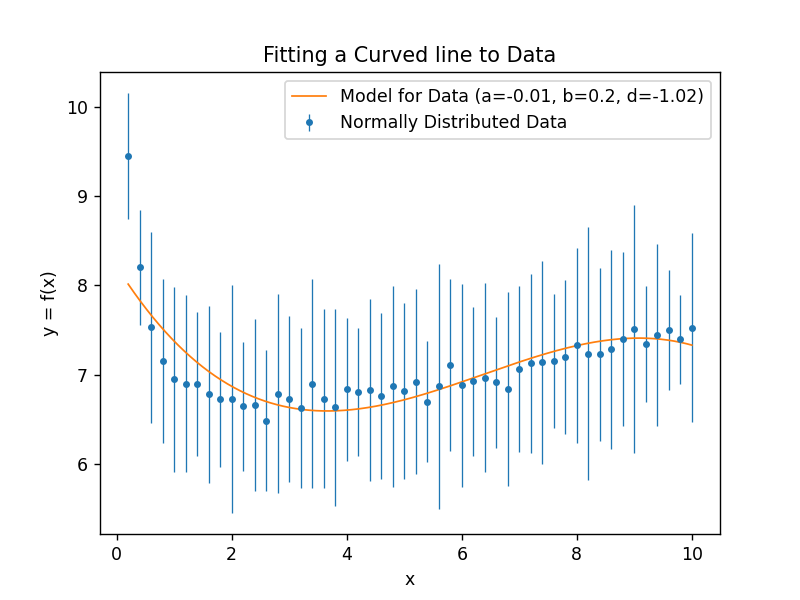

In [41]:
plt.figure()
plt.errorbar(x, y, yerr=yError, fmt='.', label='Normally Distributed Data', elinewidth=0.75)
plt.plot(xOutput, yOutput, label=f'Model for Data (a={round(Params[0], 2)}, '
         f'b={round(Params[1], 2)}, d={round(Params[2], 2)})', linewidth=1)
plt.title('Fitting a Curved line to Data')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend()
plt.show()

## Corner Plots

Parameter Space Plots.

In [55]:
ndim = 4 # our problem is 3 dimensional
nwalkers = 12 # instead of a single chain this algorithm uses several
nburnin = 100 # number of burnin iterations to run
niter = 10000 # number of iterations to run after burnin

x1 = np.random.randn(nwalkers, ndim) # choose random starting points

sampler = emcee.EnsembleSampler(nwalkers, ndim, MinuslnPosterior, args=[x, y, yError])

state = sampler.run_mcmc(x1, nburnin) # run 100 burn in iterations

sampler.reset()

state = sampler.run_mcmc(state, niter) # run for 100000 iterations

<IPython.core.display.Javascript object>


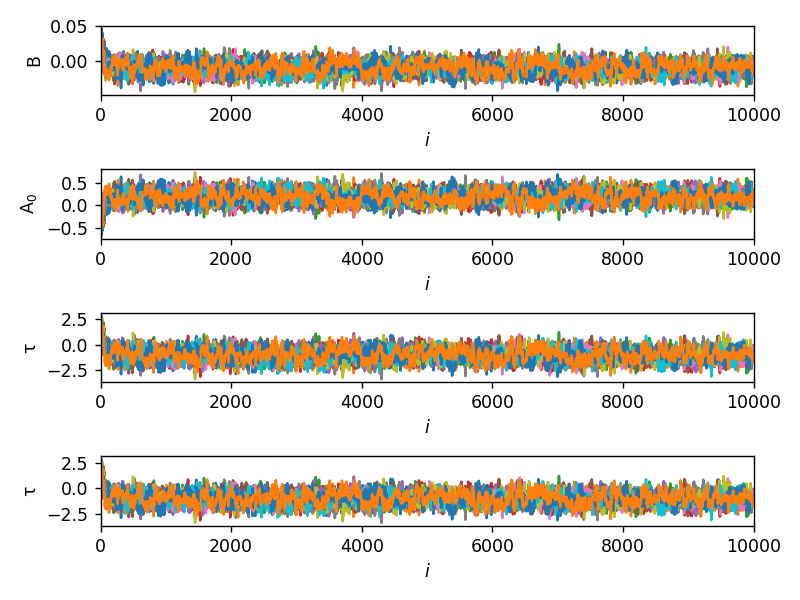

In [56]:
fig, [ax0, ax1, ax2, ax3] = plt.subplots(4, 1)

for i in range(nwalkers):
    ax0.plot(sampler.get_chain()[:,i,0])
ax0.set_xlabel(r"$i$")
ax0.set_ylabel("B")

for i in range(nwalkers):
    ax1.plot(sampler.get_chain()[:,i,1])
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"A$_0$")

for i in range(nwalkers):
    ax2.plot(sampler.get_chain()[:,i,2])
ax2.set_xlabel(r"$i$")
ax2.set_ylabel("τ")

for i in range(nwalkers):
    ax3.plot(sampler.get_chain()[:,i,2])
ax3.set_xlabel(r"$i$")
ax3.set_ylabel("τ")

x_max = niter
ax0.set_xlim(0, x_max)
ax1.set_xlim(0, x_max)
ax2.set_xlim(0, x_max)
ax3.set_xlim(0, x_max)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


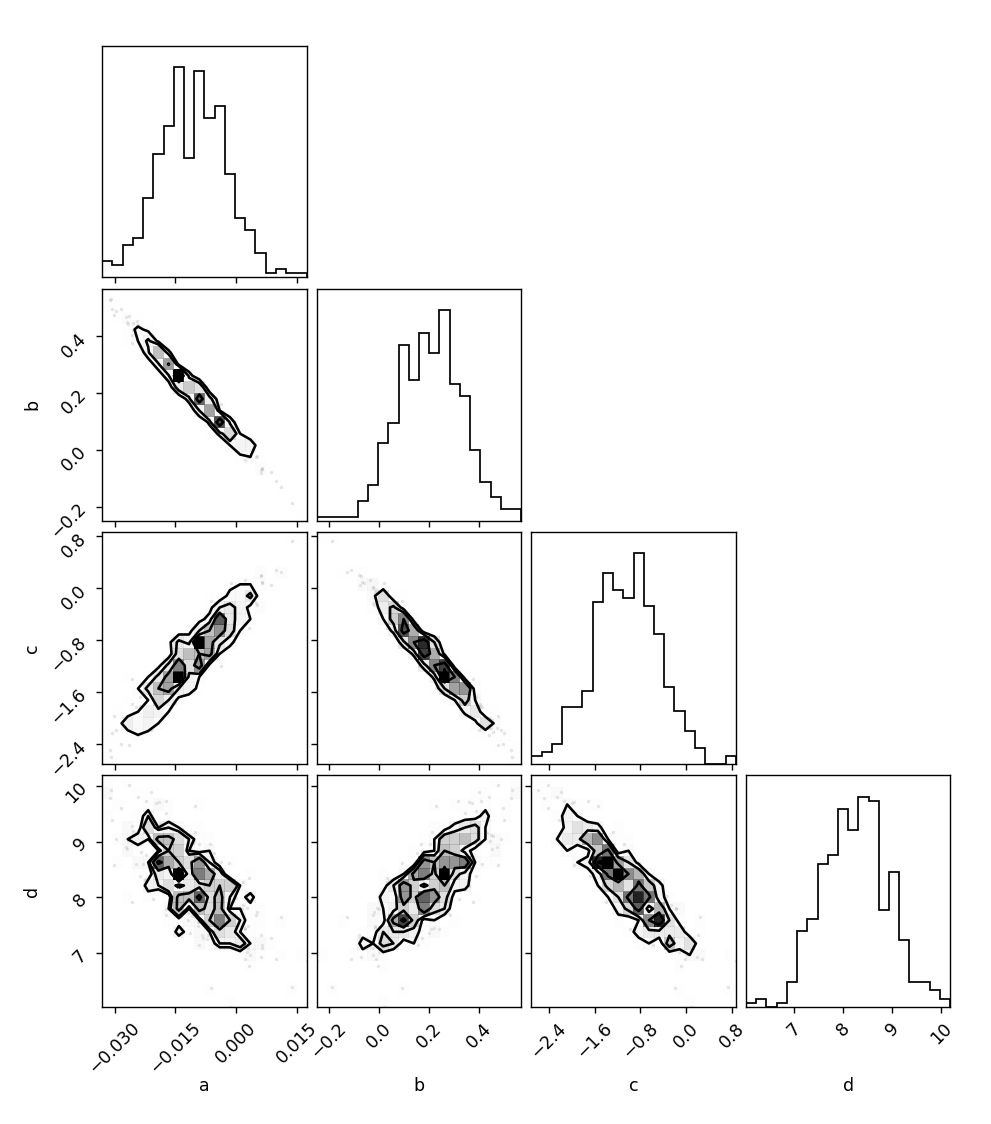

In [57]:
samples = sampler.get_chain(flat=True, thin=300)

corner.corner(samples, labels=['a', 'b', 'c', 'd'])

plt.show()